In [12]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import matplotlib.pyplot as plt
import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from inference.inference_network import InferenceNetwork
from ppo_a2c.envs import make_vec_envs_multi_task, get_vec_envs_multi_task
from task.GuassianTaskGenerator import GaussianTaskGenerator
from utilities.folder_management import handle_folder_creation


In [164]:
def get_const_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1, (1e-8, 1e8))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=False,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-10], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    mean = -5

    prior_seq = []
    for idx in range(50):
        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test

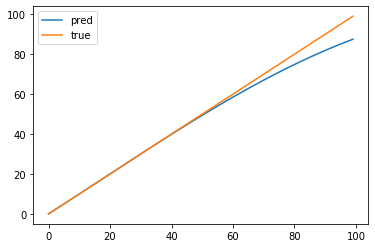

In [197]:
for _ in range(50):
    num_test_processes = 1
    gp_list, _, _ = get_const_task_sequence(1, 1, num_test_processes, 0.1)

    x_train = np.arange(40)
    y_train = np.arange(40)
    gp_list[0][0].fit(np.atleast_2d(x_train).T, np.atleast_2d(y_train).T)

    x_points = np.atleast_2d(np.arange(100)).T
    pred, sigma = gp_list[0][0].predict(x_points, return_std=True)

plt.plot(x_points, pred, label="pred")
plt.plot(x_points, np.arange(100), label="true")
plt.legend()

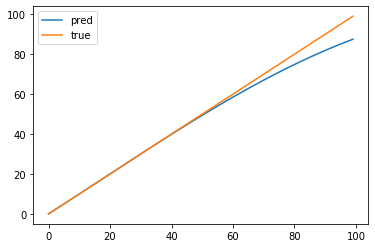

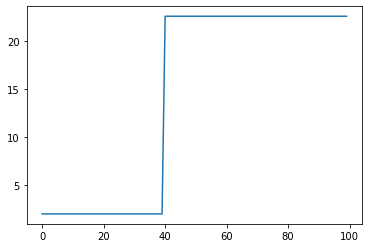

In [187]:
plt.plot(x_points, sigma)

In [84]:
sigma[0]

0.0010003569188179733

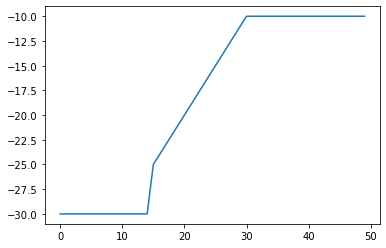

In [107]:
v = []
for idx in range(50):
    if idx < 15:
        v.append(-30)
    elif idx < 30:
        v.append(idx - 25 - 15)
    else:
        v.append(30 - 25 - 15)
plt.plot(v)

In [112]:
1e-3

0.001

In [114]:
latent_dim = 2
num_proc = 6
posterior = torch.rand((num_proc, latent_dim * 2))

In [115]:
posterior[:, 0:latent_dim]

tensor([[0.6220, 0.5175],
        [0.8198, 0.0426],
        [0.0998, 0.5589],
        [0.7028, 0.8258],
        [0.4667, 0.2491],
        [0.0918, 0.5902]])

In [120]:
torch.normal(posterior[:, 0:latent_dim], posterior[:, latent_dim:]).shape

torch.Size([6, 2])

In [122]:
torch.normal(posterior[:, 0:latent_dim], posterior[:, latent_dim:]).reshape(num_proc, latent_dim).shape

torch.Size([6, 2])

In [125]:
if np.random.binomial(n=1, p=0.5):
    print("here")

In [126]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from inference.inference_network import InferenceNetwork
from task.ExploitTaskGenerator import ExploitTaskGenerator
from utilities.folder_management import handle_folder_creation


In [127]:
env_name = "exploit-v0"
action_space = spaces.Discrete(3)
latent_dim = 1
theta_min = -0.1
theta_max = 0.1
noise_var = 0.01

device = "cpu"
task_generator = ExploitTaskGenerator(noise_var=noise_var, theta_min=theta_min, theta_max=theta_max)
f = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=1)

In [139]:
task_generator.sample_pair_tasks(1)

([{'noise_var': 0.01, 'theta': -0.10000000149011612}], None, [tensor([[0.0000],
          [0.1000]])], tensor([[-0.1000]]))

In [218]:
logvar_hat = (torch.ones(32, 1) * 0.4).log()
logvar_prior = (torch.ones(32, 1) * 20).log() 

mu_hat = torch.rand(32, 1)
mu_prior = mu_hat - 0.1

In [219]:
(torch.log(torch.prod(logvar_prior.exp(), 1) / torch.prod(logvar_hat.exp(), 1)))

tensor([3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120])

In [220]:
(torch.sum(
        -1 + (mu_hat - mu_prior).pow(2) * (1 / logvar_prior.exp()) + (logvar_hat.exp() * (1 / logvar_prior.exp())), 1))


tensor([-0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795])